# 5. Explore communication by exRNA

Transcripts located outside segmented cells are more likely to play a role in celular communication, being located outside their cell of origin and close to other populations. Thus, in the following notebook we aim to explore the commnunication patterns where exRNA could be involved

## Import packages

In [1]:
import pandas as pd
import spatialdata as sd
import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Read SpatialData object

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

# 1. Identify source cell of exRNA

We will use the function `compute_source_cells` to identify the source cell types that may contribute to the extracellular RNA detected in spatial transcriptomics data. For this, we use an expression threshold to determine which transcripts are expressed and computes the proportion of cells expressing each gene per cell type.

In [ ]:
troutpy.tl.compute_source_score(
    sdata, layer="transcripts", gene_key="feature_name", lambda_decay=0.1, copy=False, celltype_key="cell type"
)

We can plot the aggregated source cell type by gene using ``troutpy.pl.source_score_by_celltype``


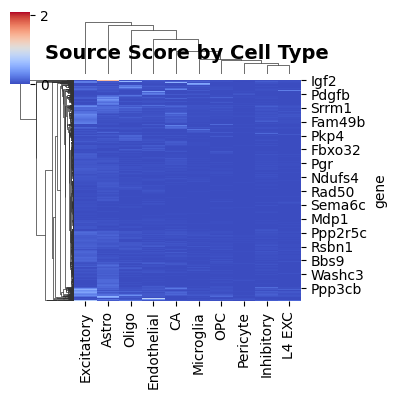

In [5]:
troutpy.pl.source_score_by_celltype(sdata,figsize=(4,4))

### 1.1 Compute distance to source cell

After computing the distance between each cell and its source, we can quantify the proportion of extracellular transcripts located away (distant transcripts) from its closest source. For this, we define a threshold distance ( in micrometers), which will be the minimum distance from each transcript to its source to consider a transcript distance. To compute the proportion of distant transcripts, we will employ the function ``troutpy.tl.compute_distant_cells_prortion``

In [31]:
troutpy.tl.compute_distant_cells_proportion(sdata, gene_id_column="feature_name", threshold=30, copy=False)

Originally we developed a function to plot this, but we could use the same one as we expect to develop to quantify RNA. Specifically
 
**PLOTTING FUNCTION 2 (troutpy.pl) Sorted scatterplot/barplot**

## 2. Identify target cell of each exRNA

Once we have explored the potential source cell of each extracellular transcript, we can also expore the most likely target cell of each exRNA analyzed. For this, we will employ ``troutpy.tl.compute_target_score``. Essentially, this function will compute the distance to its closest cells for each exRNA, using a decay function, based on lambda decay. Of course, we can't be sure that communication will occur with the closest cells. However, in case exRNA plays a role in cell-cell communication, the most likely target cell of each exRNA will be its closest cell. 

In [ ]:
troutpy.tl.compute_target_score(
    sdata,
    layer="transcripts",
    gene_id_column="feature_name",
    xcoord="x",
    ycoord="y",
    xcellcoord="x_centroid",
    ycellcoord="y_centroid",
    lambda_decay=0.1,
    copy=False,
    celltype_key="cell type",
)

For representing the target cell scores,  we could use the plotting function ``troutpy.pl.source_score_by_celltype(sdata)``

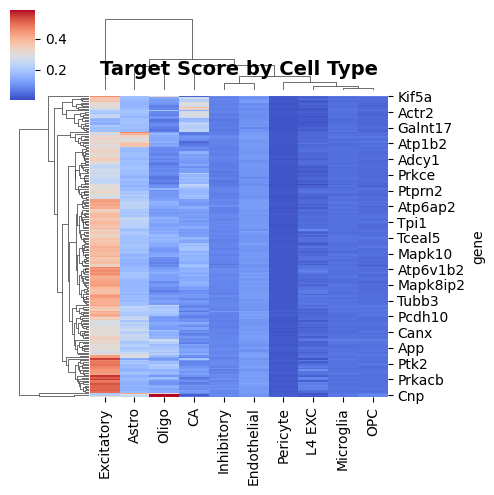

In [ ]:
troutpy.pl.target_score_by_celltype(sdata,figsize=(5,5))

### 2.1 Saving sdata as .zarr

We next save the object as zarr

In [31]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr). Please see   
         the documentation of `is_self_contained()` to understand the implications of working with SpatialData     
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr the new file path:                 
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr                                  


# 3. Communication 

After we have computed source and target scores, we can explore communication. For this, we will compute the possibility of interaction, per extracellular transcript. This is step is achieved using ```troutpy.tl.compute_communication_strength```. Results are stored under ```sdata['source_score'].uns['interaction_strenght']``` and is a 3D matrix, where we have the communication scores for each transcript and each pair of cell types (exRNA,CT,CT)
*the location of this is temporary until we find a better place to store it*

In [27]:
troutpy.tl.compute_communication_strength(sdata)

100%|█████████████████████████████████████████████████████████████████████████| 834299/834299 [03:51<00:00, 3607.83it/s]


Next, we will compile all scores by gene (G), using ```troutpy.tl.gene_specific_interactions```. The resulting 3D matrix (G,CT,CT), will be stored in ```sdata['source_score'].uns['gene_interaction_strenght']```. Gene names corresponding to the first dimension will be stored in ```sdata['source_score'].uns['gene_interaction_names']```

In [29]:
troutpy.tl.gene_specific_interactions(sdata, copy=False)

Processing categories: 100%|████████████████████████████████████████████████████████| 5566/5566 [14:23<00:00,  6.44it/s]



We first visualize the overall communication using ``troutpy.pl.celltype_interactions``

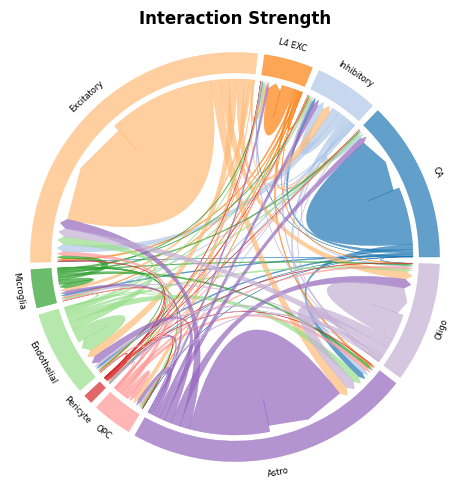

In [3]:
troutpy.pl.celltype_communication(sdata,kind="chord",
    celltype_key="cell type",figsize=(4,4))

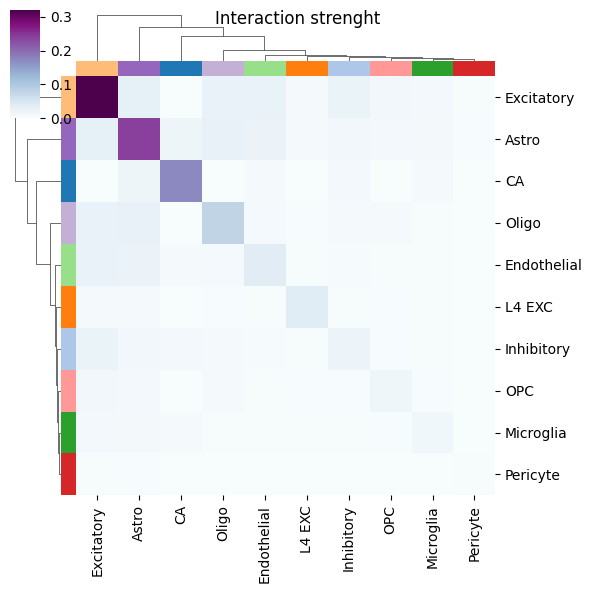

In [4]:
troutpy.pl.celltype_communication(
    sdata,
    kind="heatmap",
    celltype_key="cell type",figsize=(6,6)
)

We can also plot the gene-specific communication patterns

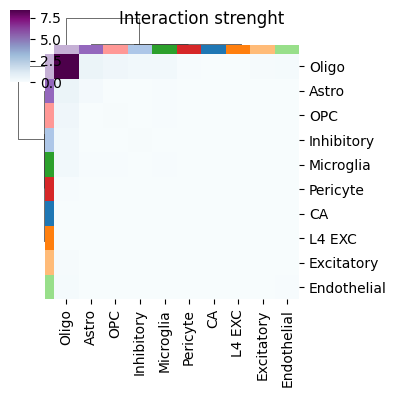

In [ ]:
troutpy.pl.gene_communication(sdata, kind="heatmap", gene="Cnp", figsize=(4, 4))

# 4. Further develop-  Directionality analysis

We are trying to develop strategies to explore wether exRNa are homogeneusly distributed arround it's source in a "diffusion" pattern, or if it present certain directionally. 

In [93]:
import seaborn as sns
from spatialdata import SpatialData
from tqdm import tqdm


def analyze_transcript_distribution_with_edge_correction(
    sdata: SpatialData,
    layer="transcripts",
    gene_id_column="feature_name",
    xcoord="x",
    ycoord="y",
    xcellcoord="x_centroid",
    ycellcoord="y_centroid",
    resolution=12,
    max_distance=50,
    edge_buffer=20,
    radius=30,  # New parameter: radius to consider for nearby transcripts
    copy=False,
):
    """
    Analyzes the extracellular distribution of transcripts for diffusion patterns and directionality,
    accounting for edge effects. Now, it considers only transcripts within a certain radius from each cell.

    Parameters
    ----------
    - radius (float, optional)
        Maximum distance (radius) from each cell to consider relevant transcripts. Default is 10 units.
    - edge_buffer (float, optional)
        Minimum distance from the boundary for cells to be included in the analysis. Default is 20 units.
    """
    # Extract spatial bounds of the region
    transcripts = sdata.points[layer].compute()
    cells = sdata["table"].to_df()
    coord_cells = sdata["table"].obsm["spatial"]
    transcripts = transcripts[transcripts["extracellular"] == False]

    # Get spatial bounds
    x_min, y_min = coord_cells.min(axis=0)
    x_max, y_max = coord_cells.max(axis=0)

    # Filter edge cells
    edge_mask = (
        (coord_cells[:, 0] > x_min + edge_buffer)
        & (coord_cells[:, 0] < x_max - edge_buffer)
        & (coord_cells[:, 1] > y_min + edge_buffer)
        & (coord_cells[:, 1] < y_max - edge_buffer)
    )
    valid_cells = cells[edge_mask]
    valid_coords = coord_cells[edge_mask]

    # Initialize results
    results = []

    for gene in tqdm(cells.columns.unique(), desc="Processing genes"):
        # Filter transcripts and edge-corrected cells for the current gene
        gene_transcripts = transcripts[transcripts[gene_id_column] == gene]
        gene_cells = valid_cells[valid_cells[gene] > 0]
        if gene_transcripts.empty or gene_cells.empty:
            continue

        # Extract coordinates
        transcript_coords = gene_transcripts[[xcoord, ycoord]].to_numpy()
        cell_coords = valid_coords[valid_cells[gene] > 0]

        # Radial distribution with edge correction (only for relevant transcripts within radius)
        radial_bins = np.linspace(0, max_distance, 50)
        radial_density = np.zeros_like(radial_bins[:-1], dtype=float)

        for cell_idx, cell_coord in enumerate(cell_coords):
            # Find transcripts within the specified radius around the current cell
            dists_to_transcripts = np.linalg.norm(transcript_coords - cell_coord, axis=1)
            relevant_transcripts = transcript_coords[dists_to_transcripts <= radius]  # Filter by distance

            if relevant_transcripts.shape[0] == 0:  # No transcripts in range
                continue

            # Compute distances to relevant transcripts
            dists = dists_to_transcripts[dists_to_transcripts <= radius]

            # Add the histogram of distances for this cell
            radial_density += np.histogram(dists, bins=radial_bins, density=True)[0]

        radial_density /= len(cell_coords)  # Normalize by the number of valid cells

        # Symmetry score
        decay_model = np.exp(-radial_bins[:-1] / (max_distance / 2))
        symmetry_score = np.corrcoef(radial_density, decay_model)[0, 1]

        # Directionality analysis with angular density
        angles = np.arctan2(
            transcript_coords[:, 1][:, None] - cell_coords[:, 1],
            transcript_coords[:, 0][:, None] - cell_coords[:, 0],
        )
        angles = angles % (2 * np.pi)
        angular_bins = np.linspace(0, 2 * np.pi, resolution + 1)
        angular_density = np.zeros(resolution, dtype=float)
        for sector_idx in range(resolution):
            sector_mask = (angles >= angular_bins[sector_idx]) & (angles < angular_bins[sector_idx + 1])
            angular_density[sector_idx] = sector_mask.sum() / transcript_coords.shape[0]

        # Directionality score
        directionality_score = np.var(angular_density)
        # if directionality_score>1000:
        #    plt.figure()
        #    sns.barplot(angular_density)
        #    plt.title(gene)
        #    plt.show()

        # Store results
        results.append(
            {
                "gene": gene,
                "symmetry_score": symmetry_score,
                "directionality_score": directionality_score,
            }
        )

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    if copy:
        return sdata.copy(), results_df
    else:
        return results_df

In [ ]:
results_df = analyze_transcript_distribution_with_edge_correction(
    sdata,
    layer="transcripts",
    gene_id_column="feature_name",
    xcoord="x",
    ycoord="y",
    xcellcoord="x_centroid",
    ycellcoord="y_centroid",
    resolution=12,
    max_distance=50,
    edge_buffer=20,
    copy=False,
)

# 5. Additional plotting for communication 

This section includes plots that were developed for previous versions of the package. Some of them might be interesting

In [ ]:
def communicating_genes_per_celltype(sdata, proportion_threshold: float = 0.2, cell_type_key="cell type"):
    """Computes the number of significant genes exchanged between source and target cell types based on their proportions in the dataset.

    Parameters
    ----------
    - sdata: AnnData object
    A spatial data object containing the 'table' and 'xrna_metadata' components.
    - proportion_threshold: float, optional (default=0.2)
    The threshold for filtering significant gene proportions. Genes with proportions above this value are considered significant.
    - cell_type_key: str, optional (default='cell type')
    The key in `adata.obs` that contains the cell type annotations.

    Returns
    -------
    - number_interactions_df: pandas.DataFrame
    A DataFrame where rows represent source cell types, columns represent target cell types, and values indicate the number of significant genes shared between them.
    """
    adata = sdata["table"]
    source_proportions = pd.DataFrame(
        sdata["xrna_metadata"].varm["source"], index=sdata["xrna_metadata"].var.index, columns=adata.obs[cell_type_key].unique().dropna()
    )
    target_proportions = pd.DataFrame(
        sdata["xrna_metadata"].varm["target"], index=sdata["xrna_metadata"].var.index, columns=adata.obs[cell_type_key].unique().dropna()
    )

    # filter the source and target cell types by defining significant proportions
    source_binary = source_proportions > proportion_threshold
    target_binary = target_proportions > proportion_threshold

    # prepare dataframe to store the number of exchanged genes
    number_interactions_df = pd.DataFrame(index=source_binary.columns, columns=target_binary.columns)

    # loop through the source and target cell types to compute the number of
    # exchanged genes
    for col in source_binary.columns:
        sig_gene_source = source_binary.index[source_binary[col]]
        for col2 in target_binary.columns:
            sig_gene_target = target_binary.index[target_binary[col2]]
            number_interactions_df.loc[col, col2] = len(set(sig_gene_source).intersection(sig_gene_target))

    number_interactions_df = number_interactions_df[number_interactions_df.index]
    number_interactions_df.columns.name = "Target cell type"
    number_interactions_df.index.name = "Source cell type"
    return number_interactions_df

In [ ]:
communications_ngenes = communicating_genes_per_celltype(sdata, proportion_threshold=0.6, cell_type_key="cell type")

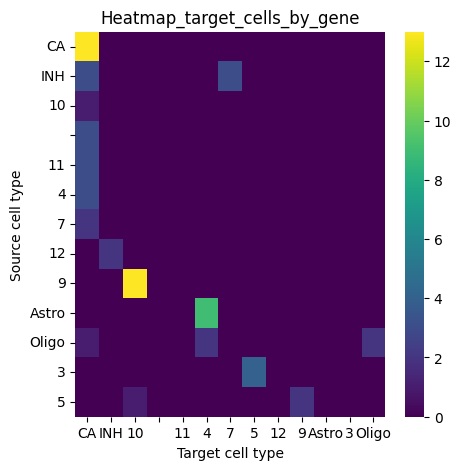

In [ ]:
troutpy.pl.sorted_heatmap(communications_ngenes.astype(float), save=False, figsize=(5, 5))

/tmp/ipykernel_1020010/2393974738.py:46: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cell_positions = pd.DataFrame(sdata['table'].obsm[spatial_key], index=sdata.table.obs[cell_id_key], columns=['x', 'y'])


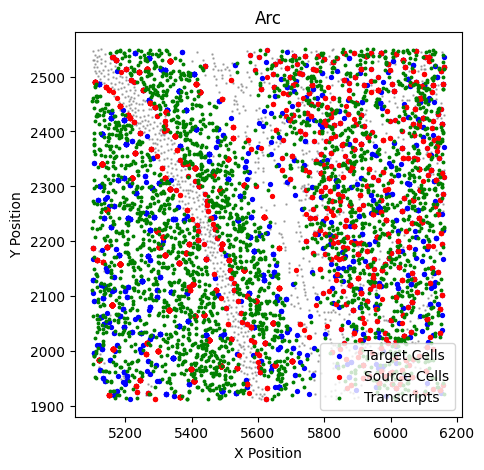

In [ ]:
troutpy.pl.spatial_interactions(sdata, layer="extracellular_transcripts_enriched", gene="Arc", gene_key="feature_name", figsize=(5, 5))

/tmp/ipykernel_1020010/732527654.py:35: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cell_positions = pd.DataFrame(sdata['table'].obsm[spatial_key], index=sdata.table.obs[cell_id_key], columns=['x', 'y'])


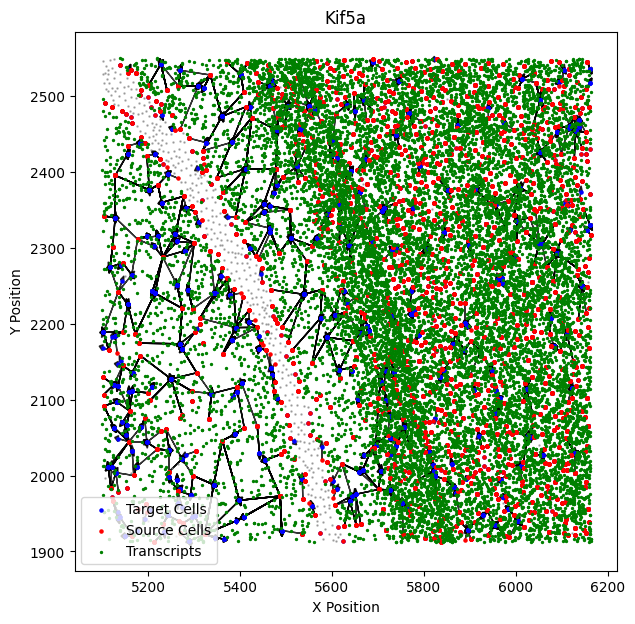

In [ ]:
troutpy.pl.interactions_with_arrows(
    sdata, layer="extracellular_transcripts_enriched", gene="Kif5a", gene_key="feature_name", figsize=(7, 7), dpi=100, size=5
)

In [ ]:
# this is completely deprecated code -->

In [ ]:
import sys

import spatialdata as sd

import troutpy 
import pandas as pd

from pathlib import Path

import pandas as pd
import scanpy as sc
import spatialdata as sd

# load and prepare data
import polars as pl
from sainsc import LazyKDE,GridCounts

from sainsc.io import read_Xenium
from sainsc.utils import celltype_signatures



# parameters
binsize_param=3
celltype_key='leiden'
background_filter=0.4
gaussian_kernel_key=2.5

transcripts_all = sdata.points["transcripts"][["feature_name", "x", "y", "codeword_category","overlaps_nucleus",'transcript_id','overlaps_cell']].compute()
transcripts_all = transcripts_all.reset_index(drop=True)
transcripts_all = transcripts_all.rename({"feature_name": "gene", "x": "x", "y": "y"})
transcripts_all = transcripts_all[transcripts_all["codeword_category"] == "predesigned_gene"]
transcripts_all= transcripts_all[transcripts_all['feature_name'].astype(str)!='nan']
transcripts=transcripts_all[["feature_name", "x", "y", "codeword_category"]]
transcripts.columns = ["gene", "x", "y", "codeword_category"]
transcripts.to_csv(compressed_transcript_csv, compression="gzip")

n_threads = 16
# Read xenium file, rename columns and filter blanks/controls
transcripts = pl.read_csv(
    compressed_transcript_csv,
    columns=["gene", "x", "y"],
    schema_overrides={"gene": pl.Categorical},
    n_threads=n_threads,
)#.filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))

brain = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=binsize_param, n_threads=n_threads)

results, shape, transcript2bin_info=process_dataframe(transcripts, binsize=binsize_param, n_threads=n_threads)
# Assuming `transcript2bin_info` is a Polars DataFrame with 'bin_x' and 'bin_y' columns, we convert it to pandas df
transcript2bin_info=transcript2bin_info.to_pandas()
# This will create a new column `bin_x_y_id` as the concatenation of 'bin_x' and 'bin_y'
transcript2bin_info['bin_x_y_id']=transcript2bin_info['bin_x'].astype(str)+'_'+transcript2bin_info['bin_y'].astype(str)

# the following lines we do to make sure that xy match in both datasets
from tqdm import tqdm
xalls=[]
for f in tqdm(transcripts_all['x']):
    xalls.append(np.round(f,4))
yalls=[]
for f in tqdm(transcripts_all['y']):
    yalls.append(np.round(f,4))
###
transcripts_all['x']=xalls
transcripts_all['y']=yalls
transcripts_all['xy']=transcripts_all['x'].astype(str)+'_'+transcripts_all['y'].astype(str)
transcript2bin_info['xy']=transcript2bin_info['x'].astype(str)+'_'+transcript2bin_info['y'].astype(str)
id2overlap=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_nucleus']))
id2overlap_cell=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_cell']))
transcript2bin_info['overlaps_nucleus']=transcript2bin_info['xy'].map(id2overlap)
transcript2bin_info['overlaps_cell']=transcript2bin_info['xy'].map(id2overlap_cell)

from tqdm import tqdm
xalls=[]
for f in tqdm(transcripts_all['x']):
    xalls.append(np.round(f,4))
yalls=[]
for f in tqdm(transcripts_all['y']):
    yalls.append(np.round(f,4))
###
transcripts_all['x']=xalls
transcripts_all['y']=yalls
transcripts_all['xy']=transcripts_all['x'].astype(str)+'_'+transcripts_all['y'].astype(str)
transcript2bin_info['xy']=transcript2bin_info['x'].astype(str)+'_'+transcript2bin_info['y'].astype(str)
id2overlap=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_nucleus']))
id2overlap_cell=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_cell']))
transcript2bin_info['overlaps_nucleus']=transcript2bin_info['xy'].map(id2overlap)
transcript2bin_info['overlaps_cell']=transcript2bin_info['xy'].map(id2overlap_cell)

brain.calculate_total_mRNA()
_ = brain.plot_genecount(im_kwargs={"vmax": 100})

_ = brain.plot_genecount_histogram()

brain.gaussian_kernel(gaussian_kernel_key, unit="um")
brain.calculate_total_mRNA_KDE()
_ = brain.plot_KDE()

_ = brain.plot_KDE_histogram(bins=200)

brain.filter_background(background_filter)

adata = sdata["table"]
expr = adata.to_df()
expr["cell type"] = adata.obs[celltype_key]
signatures = expr.groupby("cell type").mean().transpose()

brain.assign_celltype(signatures, log=True)

import colorcet as cc
import seaborn as sns

cmap = dict(zip(brain.celltypes, sns.color_palette(cc.glasbey, n_colors=len(brain.celltypes)), strict=False))

_ = brain.plot_celltype_map(cmap=cmap)

_ = brain.plot_assignment_score(remove_background=True)
_ = brain.plot_cosine_similarity()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(brain.cosine_similarity.transpose(), cmap="nipy_spectral", vmax=0.9)

import numpy as np
import pandas as pd

# Flattened features
celltype = brain.celltype_map.flatten()
assignment_score = brain.assignment_score.flatten()
cosine_similarity = brain.cosine_similarity.flatten()

# Calculate x, y coordinates based on the matrix shape
n_rows, n_cols = brain.celltype_map.shape  # Assuming brain.shape gives the shape of the matrix
x_coordinates, y_coordinates = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

# Flatten the x and y coordinates to match the flattened data
x_coordinates = x_coordinates.flatten()
y_coordinates = y_coordinates.flatten()

# Create the DataFrame with the extracted features and coordinates
output_df = pd.DataFrame({"bin_x": x_coordinates, "bin_y": y_coordinates,
    "cell type": celltype, "assignment_score": assignment_score, "cosine_similarity": cosine_similarity})

# Map the cell type numbers to their actual names
num2ct = dict(zip(range(0, len(brain.celltypes)), brain.celltypes, strict=False))
output_df["cell type"] = output_df["cell type"].map(num2ct)

output_df['bin_x_y_id']=output_df['bin_y'].astype(str)+'_'+output_df['bin_x'].astype(str)

# View the final DataFrame
output_df.head()

bin2celltype=dict(zip(output_df['bin_x_y_id'],output_df['cell type']))
bin2cosine_similarity=dict(zip(output_df['bin_x_y_id'],output_df['cosine_similarity']))
bin2assignment_score=dict(zip(output_df['bin_x_y_id'],output_df['assignment_score']))
transcript2bin_info['closest_cell_type']=transcript2bin_info['bin_x_y_id'].map(bin2celltype)
transcript2bin_info['cosine_similarity']=transcript2bin_info['bin_x_y_id'].map(bin2cosine_similarity)


# we should make the overlaps_cell column flexible, depending on the key specified. We also should make the percentile dependent on the given input
threshold=np.percentile(transcript2bin_info.loc[transcript2bin_info['overlaps_cell']==1,'cosine_similarity'],10)
transcript2bin_info['match_cell_signature']=transcript2bin_info['cosine_similarity']>threshold
print(threshold)

# important to plot
sns.displot(transcript2bin_info,x='cosine_similarity',hue='overlaps_cell')


xy2cosine_similarity=dict(zip(transcript2bin_info['xy'],transcript2bin_info['cosine_similarity']))
xy2closest_cell_type=dict(zip(transcript2bin_info['xy'],transcript2bin_info['closest_cell_type']))
transcripts_all['cosine_similarity']=transcripts_all['xy'].map(xy2cosine_similarity)
transcripts_all['closest_cell_type']=transcripts_all['xy'].map(xy2closest_cell_type)
id2cosine=dict(zip(transcripts_all.index,transcripts_all['cosine_similarity']))
id2ct=dict(zip(transcripts_all.index,transcripts_all['closest_cell_type']))
transi=sdata.points["transcripts"].compute()
transi['cosine_similarity']=transi.index.map(id2cosine)
transi['closest_cell_type']=transi.index.map(id2ct)
transi['match_cell_signature']=transi['cosine_similarity']>threshold

# now we reformat transcripts as points.

sdata.Points['transcripts']=sd.models.PointsModel.parse(transi)
#

return sdata.copy() if copy else None